# **Modelling Section**

**Welcome!**

This is the second notebook for **the scraped Gramedia dataset**. Here, we will **create and evaluate** some **models** from the data that have been cleaned before to **predict the price** and **find out** the things that have **a significant effect** to the price

Before we jump into the modelling process, I'll give some overviews for this section.

**1. Why we're doing here?**

Create the model to help publishers estimate the price to set for sale. We will do this with :

- **category** ( Fiction and Non-fiction )
- **subcategory** ( religion, education, business, local comic, manga, self-development, fiction pop, literature ), but this variable is optional since the unique values are a lot
- **region of store** ( Jabodetabek and Non-jabodetabek )
- **publisher** ( Gramedia and Non-gramedia )
- **language** ( Indonesia and English )
- **type of cover** ( Soft cover, Hard cover, and EBook )
- **Pandemic** ( Before and During)
- **pages**
- **length**
- **width**
- **weight**
- **area**

Besides that, one of the composition for creating a book is the type of paper. However, there is no information about that in there. 

Thus, **after the model has been finished later**, we can assume; or may advise to the publisher to use the same type of paper for whatever book is ( except E-book ). Why? When the publisher keep going with the quality ( in a good sign ) of paper consistently, chance the customers will be not satisfied is small.

**2. What models will be tested ?**

- XGBoost
- LightGBM
- NGBoost
- Catboost
- Blended

**3. What parameters to evaluate them?**

a. *MSE ( Mean Squared Error )*
 

Average of the square of the difference between actual and estimated values

b. *RMSE ( Root Mean Squared Error )*

Basically, this value got from square root of average error. It can a be parameter to compare the models with each other and **I would use** this to **identify** if the model is more **over/underfitting** than the others.

c. *R2 ( R-Squared )*

The proportion of the variance in the dependent variable that is predictable from the independent variable

d. *MAE ( Mean Absolute Error )*

Average of the absolute values of the difference between actual and estimated values

------------------------------------------------------------------------

For some reasons ( i.e. efficiency time ), We will only evaluate the models with RMSE and check the accuracy using R2 score in the last section

After testing the models one by one in baseline mode, I'm gonna do hyperparameter tuning and would be compare it with the baseline model

# First thing first, we'll set up the data with changing the features into numeric and remove some of them which are not important

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.pyplot import rcParams
warnings.filterwarnings('ignore')

In [131]:
pd.set_option('display.max_columns',100)
rcParams['figure.figsize'] = (15,5)
rcParams['axes.grid'] = True
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.spines.left'] = False
plt.rc('axes',axisbelow=True)

In [132]:
df = pd.read_csv('D:/Data/gramed/cleaned_data.csv')
df.head()

,link,author,title,cover,publisher,pages,publish_date,language,weight,width,length,price,store,region,category,subcategory,pandemic,area
0,https://www.gramedia.com/products/bulughul-mar...,Jabal,Bulughul Maram : Pesan-pesan Nabi Untuk Perbai...,Hard Cover,non-gramedia,412.0,2021-08-26,Indonesia,0.570,24.0,15.5,63600.0,Gramedia Depok,jabodetabek,nonfiction,agama,1,372.0
1,https://www.gramedia.com/products/inyiak-sang-...,Khairul Jasmi,Inyiak Sang Pejuang,Soft Cover,non-gramedia,275.0,2020-02-24,Indonesia,0.288,23.0,15.0,63200.0,Matraman,jabodetabek,nonfiction,agama,0,345.0
2,https://www.gramedia.com/products/dalil-dalil-...,Nur Khalik Ridwan,Dalil-Dalil Agama Gus Dur,Soft Cover,non-gramedia,378.0,2021-07-27,Indonesia,0.315,20.0,14.0,64000.0,Gramedia Botani Bogor,jabodetabek,nonfiction,agama,1,280.0
3,https://www.gramedia.com/products/doa-sang-kat...,"Anthony De Mello, Sj",Doa Sang Katak 2 - Edisi Revisi,Soft Cover,non-gramedia,320.0,2021-10-15,Indonesia,0.285,19.0,12.5,56000.0,Gramedia Karawang,non-jabodetabek,nonfiction,agama,1,237.5
4,https://www.gramedia.com/products/amalan-amala...,"NURKHOLIS, SE. MM",Amalan-Amalan Dahsyat Persiapan Hari Tua,Soft Cover,non-gramedia,232.0,2020-07-28,Indonesia,0.210,20.5,14.0,45600.0,Matraman,jabodetabek,nonfiction,agama,0,287.0


As mentioned before, we won't take the link, title, author, store, and publish date.

***Why ?***
1. In my opinion, who/whatever the author and title is, it have nothing means to the price. Except, maybe in an exclusive case such as the author is very famous, the author will be considered for the price ( very rare ). However, we'll take a normal situation that all author and title have the same affect for the price. 
2. The link and store in our data are a lot. That would be not good for our model which can lead to overfitting ( increase model complexity ). This is also the reason why we remove the author and title variables
3. Publish date : we split the date into before and during pandemic era

In [133]:
df_new = df.drop(['link','author','title','publish_date','store'],axis=1)
df_new.head()

,cover,publisher,pages,language,weight,width,length,price,region,category,subcategory,pandemic,area
0,Hard Cover,non-gramedia,412.0,Indonesia,0.570,24.0,15.5,63600.0,jabodetabek,nonfiction,agama,1,372.0
1,Soft Cover,non-gramedia,275.0,Indonesia,0.288,23.0,15.0,63200.0,jabodetabek,nonfiction,agama,0,345.0
2,Soft Cover,non-gramedia,378.0,Indonesia,0.315,20.0,14.0,64000.0,jabodetabek,nonfiction,agama,1,280.0
3,Soft Cover,non-gramedia,320.0,Indonesia,0.285,19.0,12.5,56000.0,non-jabodetabek,nonfiction,agama,1,237.5
4,Soft Cover,non-gramedia,232.0,Indonesia,0.210,20.5,14.0,45600.0,jabodetabek,nonfiction,agama,0,287.0


Since the models don't support categorical data ( even though CatBoost support for this, I'll still change the all features into numeric ), we have to change them into numerical. Bining into 1 and zero for the column that only have two unique values. If contains more, split them into new column ( one-hot encoding )

In [134]:
df_new.select_dtypes('object').nunique()

cover          3
publisher      2
language       2
region         2
category       2
subcategory    8
dtype: int64

*Language* :
- Indonesia = 1
- English   = 0

*Publisher* :
- Gramedia = 1
- Non-gramedia = 0

*Region* :
- Jabodetabek = 1
- Non-jabodetabek = 0

*Category* :
- Non-fiction = 1
- Fiction = 0

For cover and subcategory, we'll do one hot encoding

In [135]:
# cover adnd subcategory
df1 = pd.get_dummies(df_new,columns=['cover','subcategory'])

# the rest
df1.replace({'language':{'Indonesia':1,'English':0},
             'publisher':{'gramedia':1,'non-gramedia':0},
             'region':{'jabodetabek':1,'non-jabodetabek':0},
             'category':{'nonfiction':1,'fiction':0}
            },inplace=True)
df1.head()
df1 = df1[df1.price<200000]

## Understand the data

### normality

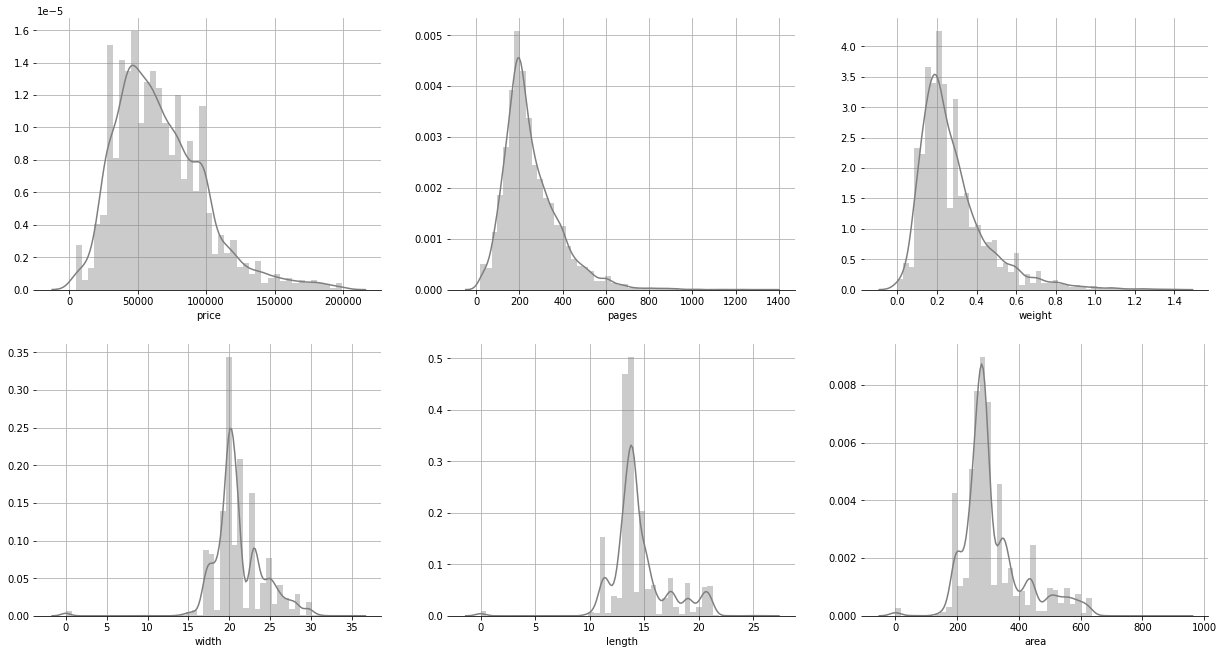

In [136]:
plt.figure(figsize=(21,11))
num = ['price','pages','weight','width','length','area']
for i in range(len(df1[num].columns)):
    plt.subplot(2,len(df1[num].columns)/2,i+1)
    sns.distplot(df1[num[i]],color='tab:grey')
    plt.ylabel('') 

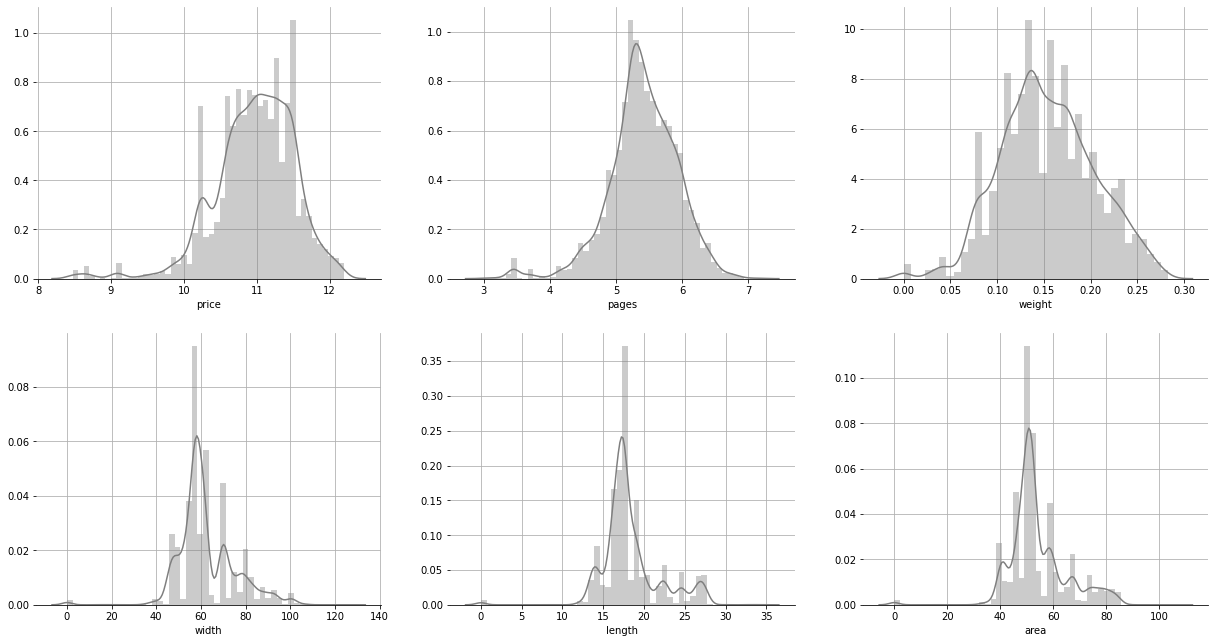

In [137]:
from scipy.stats import boxcox

plt.figure(figsize=(21,11))

df2 = df1.copy()
df2['price'] = np.log(df2.price)
df2['pages'] = np.log(df2.pages)
df2['length'], lambda1= boxcox(df2.length+1)
df2['width'], lambda2 = boxcox(df2.width+1)
df2['weight'], lambda3 = boxcox(df2.weight+1)
# df2['year_published'] = np.log(df2.year_published)
df2['area'], lambda4 = boxcox(df2.area+1)

num = ['price','pages','weight','width','length','area']
for i in range(len(df1[num].columns)):
    plt.subplot(2,len(df1[num].columns)/2,i+1)
    sns.distplot(df2[num[i]],color='tab:grey')
    plt.ylabel('') 

In [138]:
df2[num].skew()

price    -0.907548
pages    -0.607881
weight    0.057939
width     0.361227
length    0.412957
area      0.386405
dtype: float64

In [139]:
publisher = df1.publisher
df1.loc[:,'publisher'] = df.price
df1.iloc[:,6] = publisher
df1.rename({'publisher':'price','price':'publisher'},axis=1,inplace=True)

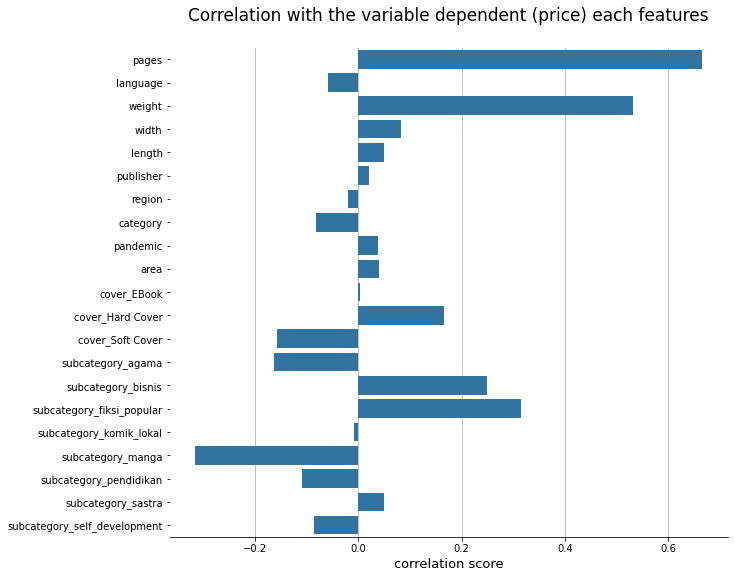

In [140]:
df1['price'] = np.log(df1.price)
df1['pages'] = np.log(df1.pages)
# df1['year_published'] = np.log(df1.year_published)

corr = df1.corr()

plt.figure(figsize=(10,9))
sns.barplot(y=corr.loc['price'][1:].index,x=corr.loc['price'][1:],color='tab:blue')
plt.title('Correlation with the variable dependent (price) each features\n',size=17)
plt.xlabel('correlation score',size=13)
plt.show()

In [141]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
# Define error metrics
X = df1.drop(['price'],axis=1)
y = df1.price
X1 = df2.drop(['price'],axis=1)
y1 = df2.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=4)

In [142]:
kf = KFold(n_splits=4, random_state=42, shuffle=True)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [143]:
from sklearn.metrics import mean_squared_error, r2_score
def eval(model):
    print(np.sqrt(mean_squared_error(y_train, model.predict(X_train))))
    print(np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    print(r2_score(y_train, model.predict(X_train)))
    print(r2_score(y_test, model.predict(X_test)))
    
score = {}

In [144]:
from xgboost import XGBRegressor

xgb = XGBRegressor(learning_rate=0.09,n_estimators=2000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)
xgb.fit(X_train, y_train)

[04:06:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0.6, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.09, max_delta_step=0,
             max_depth=4, min_child_weight=0, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=2, nthread=-1,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=42, reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1,
             seed=27, subsample=0.7, tree_method='exact', validate_parameters=1, ...)

In [145]:
eval(xgb)

0.22232963764603655
0.23670954780502662
0.8294861165610403
0.8245520386715519


In [146]:
score['XGBoost'] = 0.23670954780502662

In [147]:
from lightgbm import LGBMRegressor
lightgbm = LGBMRegressor(num_leaves=6,
                       learning_rate=0.05, 
                       n_estimators=2000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

In [148]:
lightgbm.fit(X_train,y_train)

print(np.sqrt(mean_squared_error(y_train,lightgbm.predict(X_train))))
print(np.sqrt(mean_squared_error(y_test,lightgbm.predict(X_test))))
# np.sqrt(mean_squared_error(y_train,regressor.predict(X_train)))/np.sqrt(mean_squared_error(y_test,regressor.predict(X_test)))
print(r2_score(y_train,lightgbm.predict(X_train)))
print(r2_score(y_test,lightgbm.predict(X_test)))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
0.22679248752660913
0.23984019357281464
0.8225719194874368
0.8198805108159797


In [149]:
score['Lightgbm'] = 0.23984019357281464

In [150]:
from catboost import CatBoostRegressor
catboost = CatBoostRegressor(loss_function='RMSE',
                       learning_rate=0.05, 
                       n_estimators=1500,
                       max_bin=200,
                       verbose=-1)

catboost.fit(X_train,y_train,verbose=500,eval_set=(X_test, y_test))

0:	learn: 0.5231817	test: 0.5488120	best: 0.5488120 (0)	total: 5.36ms	remaining: 8.04s
500:	learn: 0.2103221	test: 0.2324578	best: 0.2324578 (500)	total: 1.81s	remaining: 3.62s
1000:	learn: 0.1904265	test: 0.2298732	best: 0.2298599 (889)	total: 3.18s	remaining: 1.58s
1499:	learn: 0.1763550	test: 0.2302125	best: 0.2296903 (1226)	total: 5.02s	remaining: 0us

bestTest = 0.2296902662
bestIteration = 1226

Shrink model to first 1227 iterations.


In [151]:
score['Catboost'] = 0.229690262

In [152]:
from ngboost.ngboost import NGBoost
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [153]:
ngb = NGBoost(Base=default_tree_learner, Dist=Normal, natural_gradient=True,verbose=False,learning_rate=0.06,verbose_eval='neg_mean_squared_error')
ngb.fit(X_train,y_train)

In [154]:
eval(ngb)

0.21597686413741757
0.23595192901113754
0.8390913143040337
0.8256733280845404


In [155]:
score['NGBoost'] = 0.23576500788645513

In [156]:
def blended_predictions(X):
    return ((0.05 * regressor.predict(X)) + \
            (0.12 * lightgbm.predict(X)) + \
            (0.15 * ngb.predict(X)) + \
            (0.68* catboost.predict(X)))

In [157]:
blended_score = rmsle(y_test, blended_predictions(X_test))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.22867508504149311


In [158]:
score['Blended'] = 0.22863532934726205
pd.DataFrame(list(score.items()),columns=['Model','RMSE Score'])

,Model,RMSE Score
0,XGBoost,0.236710
1,Lightgbm,0.239840
2,Catboost,0.229690
3,NGBoost,0.235765
4,Blended,0.228635


The different between blended and catboost model is not significant. Thus, for time and computational efficiency, we'll choose the single model, Catboost

Check accuracy score

In [159]:
r2_score(y_test, catboost.predict(X_test))

0.8348030851015806

The model explains 83,4% of the variation in our features. It's quite good

***N.B. : I did the hyperparameter tuning in another notebook ( since I spend a bit much time to get the best results ), that's why I inputted the parameters directly in our first fitted***

In [160]:
y_pred = catboost.predict(X_test)

In [161]:
y_pred1 = pd.DataFrame(np.exp(y_pred),index=y_test.index).rename({0:'price'},axis=1)
y_test1 = pd.DataFrame(np.exp(y_test))
y_test1['type'] = 'actual'
y_pred1['type'] = 'predicted'
y_full = pd.concat([y_test1,y_pred1],axis=0)

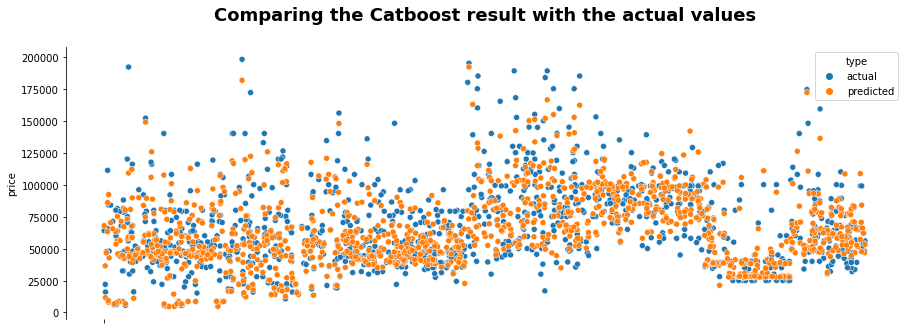

In [169]:
y_full1 = y_full.reset_index()
sns.scatterplot('index','price',hue='type',data=y_full1)
plt.title('Comparing the Catboost result with the actual values\n',size=18,fontweight=550)
plt.xlabel('')
plt.xticks([0],'')
sns.despine(bottom=True)
plt.grid(False)
plt.show()

Looks good!

# Feature Importance

Identify the importance in our features 

In [174]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],palette='Blues_r')
    #Add chart labels
    plt.title(model_type + '\nFeature Importance', size=17)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

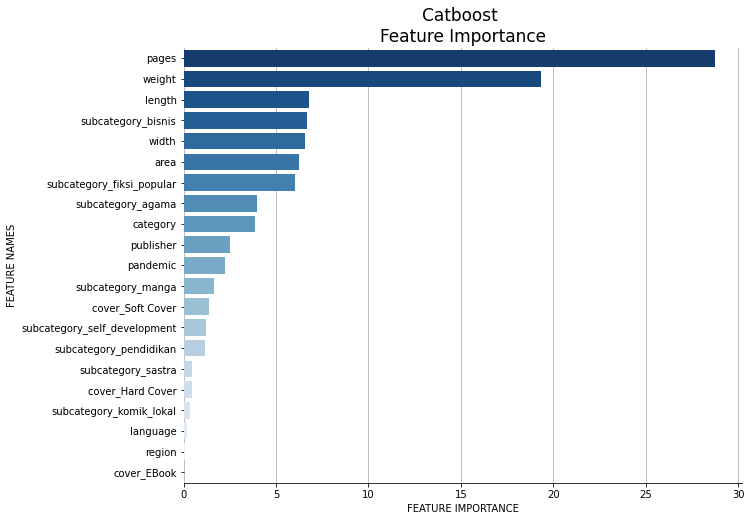

In [175]:
plot_feature_importance(catboost.get_feature_importance(),X_train.columns,'Catboost ')

Only pages and weight that have a high score. It's linear with the correlation score as we did it before which both of them have a high score

One of insights that we have is pandemic didn't effect to the book prices.